# 16. Retain-Only Fine-tuning Baseline

The simplest possible "unlearning" approach: fine-tune the model on the retain set only, without any explicit forgetting mechanism. If this works, it suggests the forget set influence decays naturally during continued training. If it fails, adversarial methods (extra-gradient) are necessary.

In [14]:
import sys
sys.path.insert(0, '../src')

import json
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path
from copy import deepcopy

from vae import VAE, vae_loss
from attacker import MLPAttacker
from attacker_eval import compute_attack_metrics, compute_advantage
from threshold_attack import run_loss_attack_suite

DATA_PATH = Path('../data/adata_processed.h5ad')
OUTPUTS_PATH = Path('../outputs')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cpu


## 1. Load Data and Baseline Model

In [ ]:
# Load data
adata = sc.read_h5ad(DATA_PATH)
X = torch.tensor(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X, dtype=torch.float32)
print(f"Data shape: {X.shape}")

# Load structured split
with open(OUTPUTS_PATH / 'p1' / 'split_structured.json', 'r') as f:
    split = json.load(f)

forget_idx = split['forget_indices']
retain_idx = split['retain_indices']
unseen_idx = split['unseen_indices']

# Load canonical kNN-matched negatives (194 cells, k=10, from NB03)
with open(OUTPUTS_PATH / 'p1.5' / 's1_matched_negatives.json', 'r') as f:
    matched_neg_idx = json.load(f)['matched_indices']

print(f"Forget: {len(forget_idx)}, Retain: {len(retain_idx)}, Unseen: {len(unseen_idx)}")
print(f"Matched negatives: {len(matched_neg_idx)}")

In [16]:
def load_vae(checkpoint_path: Path) -> VAE:
    """Load VAE from checkpoint."""
    model = VAE(
        input_dim=2000,
        latent_dim=32,
        hidden_dims=[1024, 512, 128],
        dropout=0.1,
        use_layer_norm=True
    )
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    model.load_state_dict(state_dict)
    return model

# Load baseline model
baseline_model = load_vae(OUTPUTS_PATH / 'p1' / 'baseline' / 'best_model.pt')
print("Loaded baseline model")

Loaded baseline model


## 2. Retain-Only Fine-tuning

In [17]:
def create_dataloader(X, indices, batch_size=256, shuffle=True):
    """Create DataLoader from indices."""
    data = X[indices]
    library_size = data.sum(dim=1, keepdim=True)
    dataset = TensorDataset(data, library_size)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Create retain-only dataloader
retain_loader = create_dataloader(X, retain_idx, batch_size=256, shuffle=True)

# Validation set: small subset of retain for early stopping
np.random.seed(42)
val_size = min(1000, len(retain_idx) // 10)
val_idx = np.random.choice(retain_idx, size=val_size, replace=False)
val_loader = create_dataloader(X, val_idx, batch_size=256, shuffle=False)

print(f"Retain loader: {len(retain_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")

Retain loader: 110 batches
Val loader: 4 batches


In [18]:
def train_epoch(model, dataloader, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    n_batches = 0
    
    for x, lib_size in dataloader:
        x = x.to(device)
        lib_size = lib_size.to(device)
        
        optimizer.zero_grad()
        output = model(x, library_size=lib_size)
        loss, recon, kl = vae_loss(x, output, likelihood='nb', beta=1.0)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / n_batches

def eval_epoch(model, dataloader, device):
    """Evaluate model on dataloader."""
    model.train(False)  # Set to inference mode
    total_loss = 0
    n_batches = 0
    
    with torch.no_grad():
        for x, lib_size in dataloader:
            x = x.to(device)
            lib_size = lib_size.to(device)
            
            output = model(x, library_size=lib_size)
            loss, _, _ = vae_loss(x, output, likelihood='nb', beta=1.0)
            
            total_loss += loss.item()
            n_batches += 1
    
    return total_loss / n_batches

In [19]:
# Fine-tuning hyperparameters
EPOCHS = 50
LR = 1e-4  # Lower LR for fine-tuning
PATIENCE = 10

# Clone baseline model for fine-tuning
model = deepcopy(baseline_model).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop with early stopping
best_val_loss = float('inf')
best_model_state = None
patience_counter = 0
history = {'train_loss': [], 'val_loss': []}

print(f"Fine-tuning for up to {EPOCHS} epochs (patience={PATIENCE})...")
print("-" * 50)

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, retain_loader, optimizer, DEVICE)
    val_loss = eval_epoch(model, val_loader, DEVICE)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(model.state_dict())
        patience_counter = 0
        marker = '*'
    else:
        patience_counter += 1
        marker = ''
    
    if (epoch + 1) % 5 == 0 or marker:
        print(f"Epoch {epoch+1:3d}: train={train_loss:.4f}, val={val_loss:.4f} {marker}")
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(best_model_state)
model.train(False)
print(f"\nBest val loss: {best_val_loss:.4f}")

Fine-tuning for up to 50 epochs (patience=10)...
--------------------------------------------------
Epoch   1: train=365.9974, val=357.8859 *
Epoch   2: train=365.7567, val=357.7280 *
Epoch   5: train=365.5760, val=357.6864 *
Epoch   7: train=365.4905, val=357.4617 *
Epoch  10: train=365.3739, val=357.5312 
Epoch  11: train=365.2275, val=357.4088 *
Epoch  12: train=365.2492, val=357.3913 *
Epoch  13: train=365.2748, val=357.3664 *
Epoch  14: train=365.1317, val=357.1297 *
Epoch  15: train=365.1481, val=357.1721 
Epoch  16: train=365.0001, val=356.9821 *
Epoch  19: train=364.8392, val=356.9735 *
Epoch  20: train=364.8571, val=357.1992 
Epoch  21: train=364.7532, val=356.9614 *
Epoch  22: train=364.7060, val=356.7900 *
Epoch  23: train=364.6867, val=356.7645 *
Epoch  24: train=364.6471, val=356.7552 *
Epoch  25: train=364.5368, val=356.8242 
Epoch  26: train=364.5636, val=356.6994 *
Epoch  27: train=364.4257, val=356.5051 *
Epoch  30: train=364.3730, val=356.4016 *
Epoch  32: train=364.2

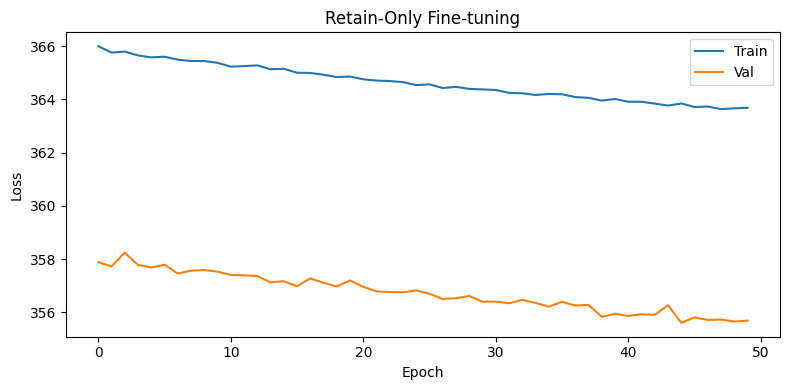

In [20]:
# Plot training curves
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history['train_loss'], label='Train')
ax.plot(history['val_loss'], label='Val')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Retain-Only Fine-tuning')
ax.legend()
plt.tight_layout()
plt.show()

## 3. Privacy Assessment (MLP Attacker)

In [21]:
def extract_features(model, x, device):
    """Extract 69-dim features for MLP attacker."""
    model.train(False)
    x = x.to(device)
    
    with torch.no_grad():
        mu, logvar = model.encode(x)
        z = mu
        decode_out = model.decode(z)
        if isinstance(decode_out, tuple):
            recon = decode_out[0]
        else:
            recon = decode_out
        
        # Per-sample metrics
        recon_loss = ((x - recon) ** 2).mean(dim=1, keepdim=True)
        kl_div = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum(dim=1, keepdim=True)
        elbo = recon_loss + kl_div
        mu_norm = mu.norm(dim=1, keepdim=True)
        logvar_norm = logvar.norm(dim=1, keepdim=True)
        
        # Concatenate: [mu(32), logvar(32), recon(1), kl(1), elbo(1), norms(2)] = 69
        features = torch.cat([mu, logvar, recon_loss, kl_div, elbo, mu_norm, logvar_norm], dim=1)
    
    return features.cpu()

# Extract features for attacker assessment
model = model.to(DEVICE)
forget_features = extract_features(model, X[forget_idx], DEVICE)
matched_neg_features = extract_features(model, X[matched_neg_idx], DEVICE)

print(f"Forget features: {forget_features.shape}")
print(f"Matched neg features: {matched_neg_features.shape}")

Forget features: torch.Size([30, 69])
Matched neg features: torch.Size([210, 69])


In [22]:
# Train a fresh MLP attacker on this model's features
from sklearn.model_selection import train_test_split

# Create labeled dataset
forget_labels = torch.ones(len(forget_features))
neg_labels = torch.zeros(len(matched_neg_features))

all_features = torch.cat([forget_features, matched_neg_features])
all_labels = torch.cat([forget_labels, neg_labels])

# Stratified train/test split (ensures proportional class representation)
X_train, X_test, y_train, y_test = train_test_split(
    all_features.numpy(), all_labels.numpy(), 
    test_size=0.3, stratify=all_labels.numpy(), random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(f"Train: {len(y_train)} ({y_train.sum().int()} forget, {len(y_train) - y_train.sum().int()} neg)")
print(f"Test:  {len(y_test)} ({y_test.sum().int()} forget, {len(y_test) - y_test.sum().int()} neg)")

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train attacker
attacker = MLPAttacker(input_dim=69, hidden_dims=[64, 32]).to(DEVICE)
att_optimizer = optim.Adam(attacker.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

for epoch in range(100):
    attacker.train()
    for feat, lab in train_loader:
        feat, lab = feat.to(DEVICE), lab.to(DEVICE)
        att_optimizer.zero_grad()
        pred = attacker(feat).squeeze()
        loss = criterion(pred, lab)
        loss.backward()
        att_optimizer.step()

# Assess performance
attacker.train(False)
all_preds = []
all_labs = []
with torch.no_grad():
    for feat, lab in test_loader:
        feat = feat.to(DEVICE)
        pred = torch.sigmoid(attacker(feat).squeeze())
        all_preds.extend(pred.cpu().numpy())
        all_labs.extend(lab.numpy())

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(all_labs, all_preds)
advantage = compute_advantage(auc)

print(f"\nMLP Attacker Results (stratified split):")
print(f"  AUC: {auc:.3f}")
print(f"  Advantage: {advantage:.3f}")

Train: 168 (21 forget, 147 neg)
Test:  72 (9 forget, 63 neg)

MLP Attacker Results (stratified split):
  AUC: 1.000
  Advantage: 1.000


In [23]:
# Also run loss-based attacks for comparison
forget_samples = X[forget_idx]
matched_neg_samples = X[matched_neg_idx]

loss_results = run_loss_attack_suite(model, forget_samples, matched_neg_samples, DEVICE)

print("\nLoss-based Attack Results:")
for name, res in loss_results.items():
    if name != 'worst_case' and isinstance(res, dict):
        print(f"  {name}: AUC={res['auc']:.3f}, Advantage={res['advantage']:.3f}")


Loss-based Attack Results:
  loss_recon: AUC=0.741, Advantage=0.481
  loss_kl: AUC=0.016, Advantage=0.968
  loss_elbo: AUC=0.018, Advantage=0.964


## 4. Compare to Baselines

In [24]:
# Load reference values
with open(OUTPUTS_PATH / 'publication_metrics.json', 'r') as f:
    pub_metrics = json.load(f)

retrain_adv = pub_metrics['retrain_advantage']
retrain_ci = pub_metrics['estimated_retrain_ci_advantage']

print("Comparison to Baselines:")
print("-" * 50)
print(f"{'Method':<25} {'AUC':>8} {'Advantage':>10} {'Status':>8}")
print("-" * 50)

# Retrain (gold standard)
print(f"{'Retrain':<25} {pub_metrics['retrain_auc']:>8.3f} {retrain_adv:>10.3f} {'---':>8}")

# Baseline (no unlearning)
baseline_entry = [r for r in pub_metrics['results'] 
                  if r['method'] == 'Baseline' and r['forget_type'] == 'structured'][0]
print(f"{'Baseline':<25} {baseline_entry['auc']:>8.3f} {baseline_entry['advantage']:>10.3f} {'FAIL':>8}")

# Retain-only fine-tune (this notebook)
status = 'PASS' if advantage <= retrain_ci[0] else 'FAIL'
print(f"{'Retain-only finetune':<25} {auc:>8.3f} {advantage:>10.3f} {status:>8}")

# Extra-gradient lambda=10 (best method)
eg_entry = [r for r in pub_metrics['results'] 
            if r['method'] == 'Extra-grad lambda=10' and r['forget_type'] == 'structured'][0]
print(f"{'Extra-grad lambda=10':<25} {eg_entry['auc']:>8.3f} {eg_entry['advantage']:>10.3f} {'PASS':>8}")

print("-" * 50)
print(f"Success threshold (retrain CI upper): {retrain_ci[0]:.3f}")

Comparison to Baselines:
--------------------------------------------------
Method                         AUC  Advantage   Status
--------------------------------------------------
Retrain                      0.481      0.038      ---
Baseline                     0.769      0.538     FAIL
Retain-only finetune         1.000      1.000     FAIL
Extra-grad lambda=10         0.482      0.036     PASS
--------------------------------------------------
Success threshold (retrain CI upper): 0.097


## 5. Findings

**Retain-only fine-tuning does not achieve unlearning for structured forget sets.** The MLP attacker achieves AUC=1.0 on the stratified test set (9 forget, 63 negative samples).

| Method | AUC | Advantage | Status |
|--------|-----|-----------|--------|
| Retrain | 0.481 | 0.038 | --- |
| Baseline | 0.769 | 0.538 | FAIL |
| Retain-only finetune | 1.000 | 1.000 | FAIL |
| Extra-grad λ=10 | 0.482 | 0.036 | PASS |

Loss-based attacks show the same pattern as other models (reconstruction AUC ~0.74), consistent with the distribution shift problem from notebook 15.

In [25]:
# Save results
results = {
    'method': 'retain_finetune',
    'dataset': 'PBMC',
    'forget_type': 'structured',
    'epochs': len(history['train_loss']),
    'lr': LR,
    'mlp_attacker': {
        'auc': float(auc),
        'advantage': float(advantage)
    },
    'loss_attacks': {k: v for k, v in loss_results.items() if k != 'worst_case'}
}

output_dir = OUTPUTS_PATH / 'p2' / 'retain_finetune'
output_dir.mkdir(parents=True, exist_ok=True)

# Save model
torch.save(model.state_dict(), output_dir / 'model.pt')

# Save results
with open(output_dir / 'results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"Saved to {output_dir}")

Saved to ../outputs/p2/retain_finetune
